### Imports

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
import glob
from karateclub import DeepWalk
from scipy.stats import entropy
import warnings
warnings.filterwarnings('ignore')

### Create heterogenous graph

In [2]:
# The code in this cell was inspired by the following resource(s):
# - https://www.geeksforgeeks.org/create-heterogeneous-graph-using-dgl-in-python/
# - https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html

# Create a heterogeneous graph using networkx
G = nx.Graph()

# Add nodes with different types
num_authors = 400
num_papers = 1400
num_conferences = 200

for i in range(1, num_authors + 1):
    G.add_node(f"author{i}", type="author")

for i in range(1, num_papers + 1):
    G.add_node(f"paper{i}", type="paper")

for i in range(1, num_conferences + 1):
    G.add_node(f"conference{i}", type="conference")

# Add edges between different types of nodes with edge types
# Each author writes 3 random papers
for i in range(1, num_authors + 1):
    authored_papers = np.random.choice(range(1, num_papers + 1), size=3, replace=False)
    for paper_id in authored_papers:
        G.add_edge(f"author{i}", f"paper{paper_id}", type="writes")

# Each paper is presented at 1 random conference
for paper_id in range(1, num_papers + 1):
    conference_id = np.random.randint(1, num_conferences + 1)
    G.add_edge(f"paper{paper_id}", f"conference{conference_id}", type="presented_at")

### Read the input graph

In [3]:
# The code in this cell was inspired by the following resource(s):
# - https://matplotlib.org/stable/api/_as_gen/matplotlib.lines.Line2D.html

# nx.write_gml(G, 'graph_tests_data/graph_test_2000_nodes.gml') # Save the graph

G = nx.read_gml('graph_tests_data/graph_test_2000_nodes.gml') # Read the graph

pos = nx.spring_layout(G, seed=42, k=0.3)  # Spring layout with adjusted k for better spacing

### Apply DeepWalk to get node embeddings

In [4]:
# The code in this cell was inspired by the following resource(s):
# - https://medium.com/@taunkdhaval08/graph-representational-learning-creating-node-and-graph-embeddings-part-2-33817c5ce7f3

# Create a mapping from original nodes to consecutive integers
node_mapping = {node: idx for idx, node in enumerate(G.nodes())}
reverse_mapping = {idx: node for node, idx in node_mapping.items()}

# Create a new graph with the mapped node indices
G_mapped = nx.Graph()
for node in G.nodes():
    G_mapped.add_node(node_mapping[node])
for edge in G.edges():
    G_mapped.add_edge(node_mapping[edge[0]], node_mapping[edge[1]])

# Fit the DeepWalk model
model = DeepWalk(dimensions=64, walk_length=30, workers=4)
model.fit(G_mapped)

# Get the embeddings
embeddings = model.get_embedding()

# Print node embeddings with original node names
for idx, embedding in enumerate(embeddings):
    original_node = reverse_mapping[idx]
    print(f"Node: {original_node}, Embedding: {embedding}")

Node: author1, Embedding: [ 0.17481434  0.85379946 -0.16276108 -0.5917475  -0.16931161 -0.31259453
  0.6970003   0.25249097  0.963079   -0.0660203  -0.84708166 -1.1748824
 -2.1262062   1.700024    0.1834612   0.06198744 -0.29158098 -2.8537107
 -0.2549231   1.0513858  -0.07544172 -1.9684092  -0.3293115   0.8052532
 -0.59159696  1.2339205   1.484331   -1.3598495  -0.26775426 -1.3098701
 -0.03565224  0.43892834  2.0179276  -1.2119838  -1.0361006   0.27431035
  1.444038    0.4078537   1.0515118   2.1607447   0.27485892  0.1519134
 -1.1657625  -1.029037   -0.8709004  -0.444063    0.52697164 -1.875528
 -0.3084705   0.07572123  0.2101021  -1.0104722  -0.54470354 -0.97352284
  1.1007105   0.22445689 -0.6139473  -0.02958929  1.3414029   1.8778551
  0.6124408   0.16844799  0.10182825  0.1692019 ]
Node: author2, Embedding: [-0.262312   -0.3333456  -0.6315221   1.0028566  -0.17715016  0.1615889
 -0.9465503  -0.5240653   0.9887623   0.64181095 -2.2969508   0.24875651
  0.61411375 -1.083589   -2.132

Node: author229, Embedding: [-0.09686517 -0.00863792  0.6122373   0.30797565 -0.9896914  -2.8777509
 -0.32967162  0.2567993  -1.2953298   1.0594479  -1.1618192   0.62862515
  0.51341814 -1.7221693   0.97348535  0.15840134  0.31786326 -1.4995121
  2.5502493   0.29908213  0.1117232   1.4621993   0.5357238  -0.66172653
  0.75950867  0.12583432 -1.158559   -1.40113    -0.99817187 -0.3539894
 -1.1860136   0.89554155 -0.07467727  0.00680871 -0.8942732  -1.5123824
 -0.5729816   0.54911333  2.837057    0.94835466  1.5456429   1.9055027
 -1.6938558  -0.5409877  -0.50349414  0.15394966  0.39491335 -2.0755315
 -0.58551896  0.43167543 -1.7735578  -0.26003313 -0.6958481   0.06286745
  0.27937838  1.9918762  -2.0721264  -0.22691683  0.48488572 -0.9436415
  0.3969381  -0.4543278   2.6546395   0.5505957 ]
Node: author230, Embedding: [ 1.5104904   1.4282035   0.37982833 -0.20455168  0.32105666 -1.0201412
 -0.46562794 -1.7158663  -0.4884097   1.7864664  -0.49407396  1.227994
 -1.0766368   0.825789   -1.

Node: paper242, Embedding: [ 0.22295707 -0.54519457  0.0038456  -0.3871716   0.0985127  -1.733434
  1.0808083  -0.6891515  -0.5888009  -0.03088569 -1.0696883   0.9249882
 -0.33677974 -0.24720712 -0.2176498  -0.30444252  0.42972696 -1.7987493
 -0.10949451 -0.0363058  -0.67136186 -0.92157274 -0.32429376  0.7053422
  0.11826643  0.510407   -1.1153947  -0.8025139  -0.56135863 -1.7474005
 -0.3204428  -0.8425703   1.1093496  -0.19736846 -1.1039408  -1.5385604
  0.02938442  0.5840928   0.51826525  1.1855063  -0.0092938   0.9517629
 -0.92903143 -0.26310414 -0.04744084  1.1313853   1.4522573  -0.73785865
 -1.9274433  -0.8266287  -1.8655375   1.280612   -0.1465374  -0.89827764
  0.48658416 -0.7630618  -0.756632    0.42494315  0.5922178  -1.1005063
 -0.9789528   0.71384186  0.4898058   0.59962904]
Node: paper243, Embedding: [-0.2869503  -1.991161    0.09429978  0.3676719  -1.2788451   0.5336795
 -1.5407343  -0.41386917 -1.0101981  -1.1806166  -1.311535    0.6858338
 -0.835835   -0.35718882  2.071

Node: paper503, Embedding: [-0.29072267  0.43917105  0.43526658 -1.4273379   0.04002305 -1.2505201
  0.6744015   0.7476175   1.0438894  -0.26002726 -1.2765507   0.636232
 -0.57341635 -0.65041757  0.99692917 -0.33712667 -0.11591009 -1.4672916
  0.4267839   0.2337307   0.28908828  0.6662893  -1.2322203   0.3886645
 -0.16553988  0.8534195  -1.611865   -1.0616812   0.20950747 -0.49138984
 -1.463844   -0.7044358   1.6300402  -1.7525055  -0.66821635  0.06142015
 -1.0162271   2.07756     1.0860134   0.32698795 -0.5480132   0.28619453
 -1.920906    0.2896434  -0.77378154 -0.565525    0.07916004 -0.85434777
 -0.9135519  -0.26283282 -0.19769482  0.01868167 -0.18871146 -1.1074363
 -1.0586321  -0.51059765  0.56313497  0.4014397  -0.00631786 -0.1630891
 -0.06723369 -0.5196034   1.291656   -0.38634533]
Node: paper504, Embedding: [-0.5577158  -0.9944235  -0.24677165 -1.0464833   0.8851087   0.03545548
 -0.5030485  -0.49784967 -0.16981694  0.8650785  -1.7912523   0.5336077
 -0.02937761 -1.255594   -0.

Node: paper876, Embedding: [ 0.65897757 -0.8786589   0.87153685  0.6480988   0.17796613 -0.1067212
  0.46075118  1.4395871  -0.5973016   0.87819344 -0.10355906  0.6417826
 -0.6214682  -0.31939232 -1.3994762  -1.2546157  -0.17025955 -0.30613384
  0.04216176  1.5813482  -0.7558549  -0.5707681   0.3569647  -0.56708926
 -0.12316795  0.7758083   0.41948774  1.2572452  -1.0727644   0.3014036
  0.624447    1.005879    1.406492    1.0810593  -0.5302196   1.0145818
  0.70066786 -1.0710886   0.34392437  0.01065027 -1.2260157   0.822152
 -0.42770672  0.69526887 -1.5057498  -1.6977997   0.10434341 -0.46868795
  1.5706507  -0.33428174  0.75881606  0.13182306 -0.8633029  -0.8573737
  0.20915423  0.28775004  0.5325471   2.1096687  -0.09474799 -1.0369047
  0.5685917  -0.577717    1.4147797  -2.5163662 ]
Node: paper877, Embedding: [-1.717996   -0.06314427 -0.1191429  -0.13598433  0.38643506 -0.79342204
  0.92002714  0.22705622  0.987559    2.1396365  -0.6461338   1.0980686
  0.8197041  -0.99589384  0.2

Node: paper1164, Embedding: [ 0.4486137  -0.56703573  0.672946    0.12711713  2.0936615  -0.12279958
  0.39468098 -0.1206872   0.3134606   0.521825   -1.156828    0.0399312
 -0.279777   -1.6856176  -0.55910474  0.61951816  0.53580946  0.49178508
 -0.22621028 -1.0180712  -0.20735972 -0.7810279  -0.68965626 -0.9095029
 -1.1937375   2.022539   -0.10750349  0.77997935  0.57467884 -0.8406923
  0.6403214   0.68609613 -0.6438329  -0.00448923 -0.0568212  -0.8555599
  0.99892896 -1.1467998  -0.23212294  1.2837446  -1.8139699   0.53920114
  0.57119966  0.5729346   0.4711747  -1.2316972   0.01361054 -0.32084498
  2.1043425  -0.55276144  0.11090724  1.0602845  -1.1152428  -0.6835171
  0.15935166  0.32333106 -1.0647359   1.431637    0.7343609  -1.5731053
  0.14851926  2.2483668   0.23003517 -1.2454351 ]
Node: paper1165, Embedding: [-0.5460076  -1.5388482   0.29795936 -0.6730383  -1.2775387   0.26233852
 -0.73410076 -2.923875   -1.2764057  -0.4808908  -0.85077214  0.7965864
 -0.08678842 -1.9907025  

Node: conference122, Embedding: [ 1.4565023   1.0310427  -1.2346452  -2.5137124   1.9901971  -2.203017
  0.8416778   0.837567    0.5111369   0.8596241  -2.1127515   0.1205077
  0.10439916 -0.71996343 -1.0857018  -2.849316   -0.5765724   0.61224365
 -0.59690523 -0.21567191  0.7608158  -1.4817607   0.18319042  1.1403162
  0.44996762 -0.4002543   1.0174173  -0.09659631 -0.39225465 -0.2883337
  0.80238414  0.25376567  2.4180038  -1.5620255   0.04536776  0.27905267
  0.6204107   0.50526255  0.55548745  0.9521469  -0.38021174  1.3806065
  1.6510153   0.35584027 -0.8584946  -2.1152     -0.94613713 -1.0974493
 -0.585229    1.1557516  -2.9862933   1.3706785  -1.5854194  -2.1975358
  0.27214995  1.1320449   0.7962094  -0.67413384  1.3306674   0.08301666
  1.1948475  -0.11090779  0.56835085  0.3482951 ]
Node: conference123, Embedding: [-0.34464055  1.0965936   0.8819873   2.4127204  -1.0828948   0.53893703
 -0.7652019  -0.41157886  0.92904335  3.9762385  -1.869502    0.10758314
  1.4138407  -1.02

### Apply PCA to reduce dimensionality of node embeddings

In [5]:
# The code in this cell was inspired by the following resource(s):
# - https://builtin.com/machine-learning/pca-in-python

# Reduce dimensionality of embeddings for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Print reduced embeddings
for node, embedding in zip(G.nodes(), reduced_embeddings):
    print(f"Node: {node}, Reduced Embedding: {embedding}")

# Define colors for each node type
color_map = {'author': 'lightblue', 'paper': 'lightgreen', 'conference': 'lightcoral'}
node_colors = [color_map[G.nodes[node]['type']] for node in G.nodes()]

Node: author1, Reduced Embedding: [-0.18063581 -0.14648326]
Node: author2, Reduced Embedding: [ 1.1229948 -1.967075 ]
Node: author3, Reduced Embedding: [-0.5030779   0.26238063]
Node: author4, Reduced Embedding: [-1.3206959  -0.13702396]
Node: author5, Reduced Embedding: [-1.6522609 -2.8872287]
Node: author6, Reduced Embedding: [ 2.3330562 -1.1573892]
Node: author7, Reduced Embedding: [ 2.236282  -0.9019124]
Node: author8, Reduced Embedding: [ 1.9971925 -0.6741291]
Node: author9, Reduced Embedding: [2.0837538 0.0807738]
Node: author10, Reduced Embedding: [-0.30930218 -2.2646923 ]
Node: author11, Reduced Embedding: [ 1.7473854 -0.4925068]
Node: author12, Reduced Embedding: [-0.7950286 -0.7143568]
Node: author13, Reduced Embedding: [ 1.3464657  -0.37853253]
Node: author14, Reduced Embedding: [2.128888  1.1376394]
Node: author15, Reduced Embedding: [0.27277508 0.5779186 ]
Node: author16, Reduced Embedding: [-0.46087462  0.1699829 ]
Node: author17, Reduced Embedding: [-1.8475889  1.0381125

Node: paper832, Reduced Embedding: [ 0.7373238 -1.5837985]
Node: paper833, Reduced Embedding: [1.5252227  0.26122117]
Node: paper834, Reduced Embedding: [-0.33725485  0.52942556]
Node: paper835, Reduced Embedding: [ 2.3402247 -1.2048815]
Node: paper836, Reduced Embedding: [-1.060605   0.8768259]
Node: paper837, Reduced Embedding: [-3.3822622 -1.4989964]
Node: paper838, Reduced Embedding: [-0.27922255 -1.9523935 ]
Node: paper839, Reduced Embedding: [-3.2283666 -2.3084068]
Node: paper840, Reduced Embedding: [-2.193398   0.8491895]
Node: paper841, Reduced Embedding: [1.9162989 1.4403691]
Node: paper842, Reduced Embedding: [1.4766012 0.5993089]
Node: paper843, Reduced Embedding: [-2.0931983  0.3481992]
Node: paper844, Reduced Embedding: [0.7457092  0.29717124]
Node: paper845, Reduced Embedding: [-2.6305368  -0.08670244]
Node: paper846, Reduced Embedding: [-0.03559329 -2.2500043 ]
Node: paper847, Reduced Embedding: [-2.7676272  -0.18213385]
Node: paper848, Reduced Embedding: [-0.78290653  0

Node: paper1320, Reduced Embedding: [-0.8180127  3.2789476]
Node: paper1321, Reduced Embedding: [-2.6296954 -1.602176 ]
Node: paper1322, Reduced Embedding: [0.6396832  0.96257883]
Node: paper1323, Reduced Embedding: [0.81059617 1.3984108 ]
Node: paper1324, Reduced Embedding: [-4.162783  -0.3801663]
Node: paper1325, Reduced Embedding: [1.7359147 0.8010594]
Node: paper1326, Reduced Embedding: [-0.23991321  2.5785375 ]
Node: paper1327, Reduced Embedding: [-1.6557212  0.0092221]
Node: paper1328, Reduced Embedding: [-0.3414944  2.0067344]
Node: paper1329, Reduced Embedding: [-1.9421436 -0.9613289]
Node: paper1330, Reduced Embedding: [-0.7464604 -1.6328022]
Node: paper1331, Reduced Embedding: [2.0865912 1.5854744]
Node: paper1332, Reduced Embedding: [-0.03414984 -0.5898687 ]
Node: paper1333, Reduced Embedding: [ 3.3310268 -1.4099262]
Node: paper1334, Reduced Embedding: [1.5258157 1.1604337]
Node: paper1335, Reduced Embedding: [-2.5436509 -0.8311402]
Node: paper1336, Reduced Embedding: [-1.69

### Cluster reduced node embeddings

In [6]:
# The code in this cell was inspired by the following resource(s):
# - https://www.w3schools.com/python/python_ml_k-means.asp

# Apply K-Means clustering
num_clusters = 3  # Define the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(reduced_embeddings)
clusters = kmeans.labels_

# Print clusters
for node, cluster in zip(G.nodes(), clusters):
    print(f"Node: {node}, Cluster: {cluster}")

# Define a color map for clusters
color_map = plt.get_cmap('viridis', num_clusters)

Node: author1, Cluster: 2
Node: author2, Cluster: 2
Node: author3, Cluster: 0
Node: author4, Cluster: 0
Node: author5, Cluster: 2
Node: author6, Cluster: 1
Node: author7, Cluster: 1
Node: author8, Cluster: 1
Node: author9, Cluster: 1
Node: author10, Cluster: 2
Node: author11, Cluster: 1
Node: author12, Cluster: 2
Node: author13, Cluster: 1
Node: author14, Cluster: 1
Node: author15, Cluster: 1
Node: author16, Cluster: 0
Node: author17, Cluster: 0
Node: author18, Cluster: 2
Node: author19, Cluster: 0
Node: author20, Cluster: 0
Node: author21, Cluster: 0
Node: author22, Cluster: 1
Node: author23, Cluster: 1
Node: author24, Cluster: 1
Node: author25, Cluster: 1
Node: author26, Cluster: 1
Node: author27, Cluster: 1
Node: author28, Cluster: 2
Node: author29, Cluster: 2
Node: author30, Cluster: 2
Node: author31, Cluster: 2
Node: author32, Cluster: 2
Node: author33, Cluster: 1
Node: author34, Cluster: 1
Node: author35, Cluster: 1
Node: author36, Cluster: 1
Node: author37, Cluster: 1
Node: auth

### Identify central nodes using centrality measures

In [7]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# Print centrality measures
print("\n######### Degree Centrality: #########")
for node, centrality in degree_centrality.items():
    print(f"Node: {node}, Centrality: {centrality}")

print("\n######### Betweenness Centrality: #########")
for node, centrality in betweenness_centrality.items():
    print(f"Node: {node}, Centrality: {centrality}")

print("\n######### Eigenvector Centrality: #########")
for node, centrality in eigenvector_centrality.items():
    print(f"Node: {node}, Centrality: {centrality}")

# Identify central nodes in each cluster using different centrality measures
central_nodes = {i: {} for i in range(num_clusters)}
centrality_measures = {
    'degree': degree_centrality,
    'betweenness': betweenness_centrality,
    'eigenvector': eigenvector_centrality
}

for measure_name, centrality in centrality_measures.items():
    for i in range(num_clusters):
        cluster_nodes = [node for node, cluster in zip(G.nodes(), clusters) if cluster == i]
        if not cluster_nodes:
            print(f"Cluster {i} is empty for {measure_name} centrality")
            continue
        cluster_centralities = {node: centrality[node] for node in cluster_nodes}
        sorted_cluster_nodes = sorted(cluster_centralities, key=cluster_centralities.get, reverse=True)
        central_nodes[i][measure_name] = sorted_cluster_nodes[:10]  # Top 10 central nodes in each cluster

# Print central nodes
for cluster, nodes in central_nodes.items():
    print(f"\nCluster {cluster}:")
    for measure, top_nodes in nodes.items():
        print(f"  {measure.capitalize()} Centrality: {top_nodes}")
        
# Initialize an empty set to collect all identified nodes
identified_nodes = set()

# Iterate over central_nodes dictionary and collect nodes into the set
for cluster, nodes in central_nodes.items():
    for measure, top_nodes in nodes.items():
        identified_nodes.update(top_nodes)

# Convert the set to a sorted list
identified_nodes_list = sorted(list(identified_nodes))

# Print the list of identified nodes
print("List of Identified Nodes:")
for node in identified_nodes_list:
    print(node)


######### Degree Centrality: #########
Node: author1, Centrality: 0.0015007503751875936
Node: author2, Centrality: 0.0015007503751875936
Node: author3, Centrality: 0.0015007503751875936
Node: author4, Centrality: 0.0015007503751875936
Node: author5, Centrality: 0.0015007503751875936
Node: author6, Centrality: 0.0015007503751875936
Node: author7, Centrality: 0.0015007503751875936
Node: author8, Centrality: 0.0015007503751875936
Node: author9, Centrality: 0.0015007503751875936
Node: author10, Centrality: 0.0015007503751875936
Node: author11, Centrality: 0.0015007503751875936
Node: author12, Centrality: 0.0015007503751875936
Node: author13, Centrality: 0.0015007503751875936
Node: author14, Centrality: 0.0015007503751875936
Node: author15, Centrality: 0.0015007503751875936
Node: author16, Centrality: 0.0015007503751875936
Node: author17, Centrality: 0.0015007503751875936
Node: author18, Centrality: 0.0015007503751875936
Node: author19, Centrality: 0.0015007503751875936
Node: author20, Cen

### Compute edge embeddings

In [8]:
# The code in this cell was inspired by the following resource(s):
# - https://github.com/benedekrozemberczki/M-NMF

# Compute adjacency matrix
adj_matrix = nx.to_numpy_array(G)

# Perform NMF on adjacency matrix
nmf = NMF(n_components=64, random_state=42)
W = nmf.fit_transform(adj_matrix)
H = nmf.components_

# Standardize W and H
W = StandardScaler().fit_transform(W)
H = StandardScaler().fit_transform(H.T)

# Compute edge embeddings using matrix factorization
edge_embeddings_nmf = {}
for edge in G.edges():
    u, v = edge
    u_idx = list(G.nodes()).index(u)
    v_idx = list(G.nodes()).index(v)
    embedding = np.concatenate([W[u_idx], H[v_idx]])
    edge_embeddings_nmf[edge] = embedding

### Apply PCA to reduce dimensionality of edge embeddings

In [9]:
# Reduce dimensionality of embeddings for visualization
edge_embeddings_nmf_array = np.array(list(edge_embeddings_nmf.values()))
pca = PCA(n_components=2)
reduced_edge_embeddings_nmf = pca.fit_transform(edge_embeddings_nmf_array)

# Print reduced edge embeddings (NMF)
print("Edge embeddings from NMF:")
for edge, embedding in zip(edge_embeddings_nmf.keys(), reduced_edge_embeddings_nmf):
    print(f"Edge: {edge}, Reduced Embedding: {embedding}")

Edge embeddings from NMF:
Edge: ('author1', 'paper1039'), Reduced Embedding: [-0.13714812 -0.00699559]
Edge: ('author1', 'paper991'), Reduced Embedding: [-0.13873337 -0.00678339]
Edge: ('author1', 'paper1300'), Reduced Embedding: [-0.13272737 -0.00715277]
Edge: ('author2', 'paper901'), Reduced Embedding: [-0.14239619 -0.00662906]
Edge: ('author2', 'paper567'), Reduced Embedding: [-0.14268438 -0.00666644]
Edge: ('author2', 'paper1063'), Reduced Embedding: [-0.13668441 -0.00698637]
Edge: ('author3', 'paper991'), Reduced Embedding: [-0.14951155 -0.00617566]
Edge: ('author3', 'paper685'), Reduced Embedding: [-0.18268305 -0.00417684]
Edge: ('author3', 'paper956'), Reduced Embedding: [-0.15548016 -0.00581729]
Edge: ('author4', 'paper529'), Reduced Embedding: [-0.14201392 -0.00662132]
Edge: ('author4', 'paper693'), Reduced Embedding: [-0.1474576 -0.0062951]
Edge: ('author4', 'paper1354'), Reduced Embedding: [-0.14142773 -0.00669233]
Edge: ('author5', 'paper1084'), Reduced Embedding: [-0.13126

Edge: ('paper303', 'conference69'), Reduced Embedding: [-0.34934216 -0.04915769]
Edge: ('paper304', 'conference107'), Reduced Embedding: [-0.25869696  0.02675261]
Edge: ('paper305', 'conference75'), Reduced Embedding: [-0.24284353  0.53791698]
Edge: ('paper306', 'conference123'), Reduced Embedding: [-0.61160186 -1.37790435]
Edge: ('paper307', 'conference188'), Reduced Embedding: [-0.19425889  0.29854461]
Edge: ('paper308', 'conference18'), Reduced Embedding: [-0.22854837  0.01861543]
Edge: ('paper309', 'conference47'), Reduced Embedding: [-0.12935516 -0.00571272]
Edge: ('paper310', 'conference63'), Reduced Embedding: [-1.86539582  1.11670661]
Edge: ('paper311', 'conference28'), Reduced Embedding: [-0.16811297 -0.02886395]
Edge: ('paper312', 'conference130'), Reduced Embedding: [-0.13393391 -0.20824602]
Edge: ('paper313', 'conference173'), Reduced Embedding: [-0.39952004  1.06895559]
Edge: ('paper314', 'conference87'), Reduced Embedding: [-0.18840978  0.02010647]
Edge: ('paper315', 'con

### Measure edge importance using Non-Negative Matrix Factorisation (NMF)

In [10]:
# Measure edge influence for NMF
edge_influence_nmf = {edge: np.linalg.norm(embedding) for edge, embedding in edge_embeddings_nmf.items()}

# Sort edges by influence measure (NMF)
sorted_edges_nmf = sorted(edge_influence_nmf.items(), key=lambda x: x[1], reverse=True)

### Create sampled subgraph using central nodes

In [11]:
# Define the node types and their colors
node_type_color_map = {
    'author': 'lightblue',
    'paper': 'lightgreen',
    'conference': 'lightcoral'
}

# Example of setting node types in the graph (if not already set)
for node in G.nodes():
    if 'author' in node:
        G.nodes[node]['type'] = 'author'
    elif 'paper' in node:
        G.nodes[node]['type'] = 'paper'
    elif 'conference' in node:
        G.nodes[node]['type'] = 'conference'
        
# Create a subgraph with only the key important nodes
subgraph = G.subgraph(identified_nodes_list).copy()

# Extend the subgraph by including neighbors of the key nodes
extended_nodes = set(identified_nodes_list)
for node in identified_nodes_list:
    extended_nodes.update(G.neighbors(node))

# Create an extended subgraph
extended_subgraph = G.subgraph(extended_nodes).copy()

# Remove isolated nodes (nodes with no edges) from the extended subgraph
isolated_nodes = [node for node in extended_subgraph.nodes if extended_subgraph.degree(node) == 0]
extended_subgraph.remove_nodes_from(isolated_nodes)
    
# Print the number of nodes in the graph
num_nodes = extended_subgraph.number_of_nodes()
print(f"Number of nodes in the graph: {num_nodes}")

pos = nx.spring_layout(extended_subgraph, seed=42, k=0.3)  # Spring layout with adjusted k for better spacing

Number of nodes in the graph: 487


### Create subgraph using both central nodes and important edges

In [12]:
# Compute adjacency matrix for the extended subgraph
adj_matrix = nx.to_numpy_array(extended_subgraph)

# Perform NMF on adjacency matrix
nmf = NMF(n_components=64, random_state=42)
W = nmf.fit_transform(adj_matrix)
H = nmf.components_

# Standardize W and H
W = StandardScaler().fit_transform(W)
H = StandardScaler().fit_transform(H.T)

# Compute edge embeddings using matrix factorization
edge_embeddings_nmf = {}
for edge in extended_subgraph.edges():
    u, v = edge
    u_idx = list(extended_subgraph.nodes()).index(u)
    v_idx = list(extended_subgraph.nodes()).index(v)
    embedding = np.concatenate([W[u_idx], H[v_idx]])
    edge_embeddings_nmf[edge] = embedding

# Measure edge influence for NMF
edge_influence_nmf = {edge: np.linalg.norm(embedding) for edge, embedding in edge_embeddings_nmf.items()}

# Define a threshold for important edges (keep top 60% most influential edges)
threshold = np.percentile(list(edge_influence_nmf.values()), 10)
important_edges = [edge for edge, influence in edge_influence_nmf.items() if influence >= threshold]

# Filter the extended subgraph to include only important edges
important_subgraph = extended_subgraph.edge_subgraph(important_edges).copy()

# Remove isolated nodes (nodes with no edges) from the important subgraph
isolated_nodes = [node for node in important_subgraph.nodes if important_subgraph.degree(node) == 0]
important_subgraph.remove_nodes_from(isolated_nodes)

# Print the number of nodes
num_nodes = important_subgraph.number_of_nodes()
print(f"Number of nodes in the graph important_subgraph: {num_nodes}")

Number of nodes in the graph important_subgraph: 446


### Evaluate pruning model

In [13]:
def evaluate_graph_statistics(original_graph, sampled_graph):
    statistics = {}

    # Number of Nodes
    original_num_nodes = len(original_graph.nodes())
    sampled_num_nodes = len(sampled_graph.nodes())
    statistics['Number of nodes'] = (original_num_nodes, sampled_num_nodes)

    # Number of Edges
    original_num_edges = len(original_graph.edges())
    sampled_num_edges = len(sampled_graph.edges())
    statistics['Number of edges'] = (original_num_edges, sampled_num_edges)

    # Average Degree
    original_avg_degree = sum(dict(original_graph.degree()).values()) / original_num_nodes
    sampled_avg_degree = sum(dict(sampled_graph.degree()).values()) / sampled_num_nodes
    statistics['Average node degree'] = (original_avg_degree, sampled_avg_degree)

    # Average Clustering Coefficient
    original_avg_clustering = nx.average_clustering(original_graph)
    sampled_avg_clustering = nx.average_clustering(sampled_graph)
    statistics['Average clustering coefficient'] = (original_avg_clustering, sampled_avg_clustering)

    # Average Path Length
    if nx.is_connected(original_graph) and nx.is_connected(sampled_graph):
        original_avg_path_length = nx.average_shortest_path_length(original_graph)
        sampled_avg_path_length = nx.average_shortest_path_length(sampled_graph)
        statistics['Average path length'] = (original_avg_path_length, sampled_avg_path_length)
    else:
        statistics['Average path length'] = ('Graph is not connected', 'Graph is not connected')

    # Average Betweenness Centrality
    original_avg_betweenness = np.mean(list(nx.betweenness_centrality(original_graph).values()))
    sampled_avg_betweenness = np.mean(list(nx.betweenness_centrality(sampled_graph).values()))
    statistics['Average betweenness centrality'] = (original_avg_betweenness, sampled_avg_betweenness)

    # Average Closeness Centrality
    original_avg_closeness = np.mean(list(nx.closeness_centrality(original_graph).values()))
    sampled_avg_closeness = np.mean(list(nx.closeness_centrality(sampled_graph).values()))
    statistics['Average closeness centrality'] = (original_avg_closeness, sampled_avg_closeness)

    # Average Degree Centrality
    original_avg_degree_centrality = np.mean(list(nx.degree_centrality(original_graph).values()))
    sampled_avg_degree_centrality = np.mean(list(nx.degree_centrality(sampled_graph).values()))
    statistics['Average degree centrality'] = (original_avg_degree_centrality, sampled_avg_degree_centrality)

    # Average Eigenvector Centrality
    try:
        original_eigenvector_centrality = nx.eigenvector_centrality(original_graph, max_iter=1000)
        original_avg_eigenvector_centrality = np.mean(list(original_eigenvector_centrality.values()))
    except nx.PowerIterationFailedConvergence:
        original_avg_eigenvector_centrality = 'Convergence Failed'

    try:
        sampled_eigenvector_centrality = nx.eigenvector_centrality(sampled_graph, max_iter=1000)
        sampled_avg_eigenvector_centrality = np.mean(list(sampled_eigenvector_centrality.values()))
    except nx.PowerIterationFailedConvergence:
        sampled_avg_eigenvector_centrality = 'Convergence Failed'

    statistics['Average eigenvector centrality'] = (original_avg_eigenvector_centrality, sampled_avg_eigenvector_centrality)

    # Density
    original_density = nx.density(original_graph)
    sampled_density = nx.density(sampled_graph)
    statistics['Density'] = (original_density, sampled_density)

    return statistics


def print_and_collect_statistics_comparison(statistics):
    comparison_data = []

    for metric, values in statistics.items():
        try:
            # Convert string values to floats if possible
            original_value = float(values[0]) if isinstance(values[0], (int, float)) else values[0]
            sampled_value = float(values[1]) if isinstance(values[1], (int, float)) else values[1]
            
            # Compute the absolute difference if both values are numeric
            if isinstance(original_value, (int, float)) and isinstance(sampled_value, (int, float)):
                difference = abs(original_value - sampled_value)
            else:
                difference = 'N/A'
        except ValueError:
            # Handle non-numeric values separately
            difference = 'N/A'
        
        comparison_data.append([metric, original_value, sampled_value, difference])

    return comparison_data

# Example usage:
# Assuming G and important_subgraph are defined as the original and sampled graphs respectively
stats_comparison = evaluate_graph_statistics(G, important_subgraph)
comparison_data = print_and_collect_statistics_comparison(stats_comparison)

# Create DataFrame from the comparison data
df_comparison = pd.DataFrame(comparison_data, columns=['Metric', 'Original', 'Sampled', 'Difference'])
print(df_comparison)

                           Metric                Original  \
0                 Number of nodes                  2000.0   
1                 Number of edges                  2600.0   
2             Average node degree                     2.6   
3  Average clustering coefficient                     0.0   
4             Average path length  Graph is not connected   
5  Average betweenness centrality                0.004058   
6    Average closeness centrality                 0.10859   
7       Average degree centrality                0.001301   
8  Average eigenvector centrality                0.003464   
9                         Density                0.001301   

                  Sampled Difference  
0                   446.0     1554.0  
1                   422.0     2178.0  
2                1.892377   0.707623  
3                     0.0        0.0  
4  Graph is not connected        N/A  
5                0.001971   0.002087  
6                0.023037   0.085553  
7               

In [14]:
df_comparison

,Metric,Original,Sampled,Difference
0,Number of nodes,2000.0,446.0,1554.0
1,Number of edges,2600.0,422.0,2178.0
2,Average node degree,2.6,1.892377,0.707623
3,Average clustering coefficient,0.0,0.0,0.0
4,Average path length,Graph is not connected,Graph is not connected,N/A
5,Average betweenness centrality,0.004058,0.001971,0.002087
6,Average closeness centrality,0.10859,0.023037,0.085553
7,Average degree centrality,0.001301,0.004253,0.002952
8,Average eigenvector centrality,0.003464,0.010197,0.006733
9,Density,0.001301,0.004253,0.002952


In [15]:
# df_comparison.to_csv('results99.csv', index=False)  # Set index=False to exclude row numbers in the CSV

### Evaluating model on graph of 2000 nodes

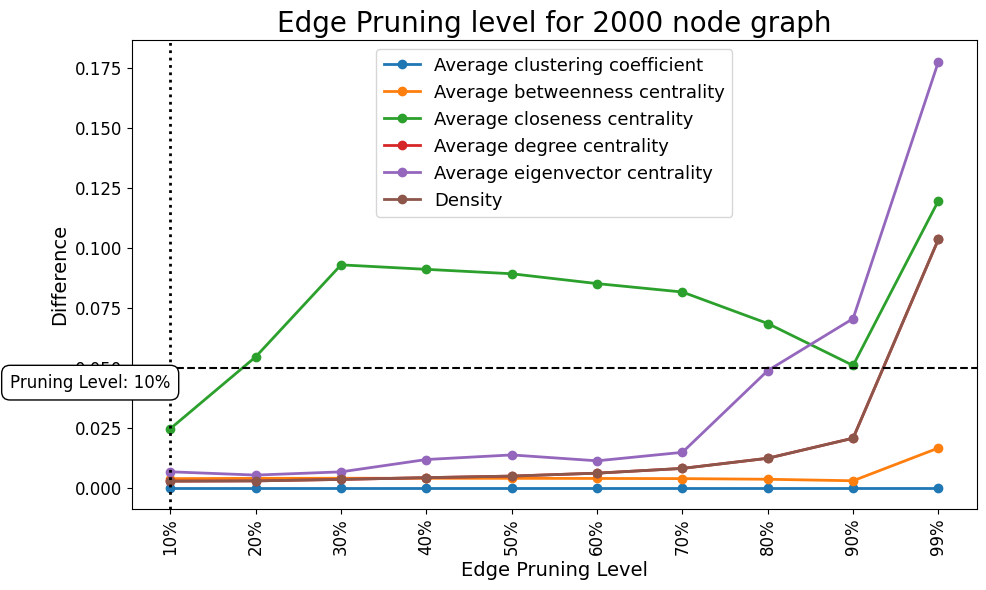

In [16]:
# Function to read CSV and plot the 'Difference' column for each row
def plot_differences():
    # Use glob to find all CSV files in the specified directory
    csv_files = glob.glob('../results/csv_results/DeepWalk_csv_results/2000_node_graph_csv_results/*.csv') ##EMPTY
    csv_files.sort()  # Sort the files to ensure consistent order

    # List to store the DataFrames
    all_dataframes = []

    for file in csv_files:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file)
        all_dataframes.append(df)

    # Get the list of row labels (metrics) from the first DataFrame and remove unwanted metrics
    row_labels = all_dataframes[0]['Metric'].tolist()
    unwanted_metrics = ['Number of nodes', 'Number of edges', 'Average node degree', 'Average path length']
    row_labels = [metric for metric in row_labels if metric not in unwanted_metrics]

    # Create a dictionary to store differences for each metric
    all_differences = {metric: [] for metric in row_labels}

    # Iterate over each DataFrame and populate the differences for each metric
    for df in all_dataframes:
        for metric in row_labels:
            difference = df[df['Metric'] == metric]['Difference'].astype(float).values[0]
            all_differences[metric].append(difference)

    # Generate x-tick labels as percentages, ending with 99%
    num_files = len(csv_files)
    percentage_labels = [f'{i*10}%' for i in range(1, num_files)]
    percentage_labels.append('99%')

    # Ensure percentage_labels has the same length as the number of files
    percentage_labels = percentage_labels[:num_files]

    # Plot the differences for each metric
    plt.figure(figsize=(10, 6))

    for metric, differences in all_differences.items():
        plt.plot(percentage_labels, differences, marker='o', label=metric, linewidth=2)  # Increased line thickness

    # Add a horizontal line at 0.05
    threshold = 0.05
    plt.axhline(y=threshold, color='black', linestyle='--', linewidth=1.5)

    # Find the maximum pruning level where all differences are below 0.05
    max_pruning_level = None
    for i, diffs in enumerate(zip(*all_differences.values())):
        if all(diff < 0.05 for diff in diffs):
            max_pruning_level = i
        else:
            break

    # Annotate the plot with the maximum pruning level
    if max_pruning_level is not None:
        plt.axvline(x=max_pruning_level, color='black', linestyle=':', linewidth=2)
        plt.text(max_pruning_level, 0.04, f'Pruning Level: {percentage_labels[max_pruning_level]}',
                 verticalalignment='bottom', horizontalalignment='right',
                 color='black', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    plt.xticks(rotation=90, fontsize=12)  # Increased x-tick size
    plt.yticks(fontsize=12)  # Increased y-tick size
    plt.xlabel('Edge Pruning Level', fontsize=14)  # Updated x-label size
    plt.ylabel('Difference', fontsize=14)  # Updated y-label size
    plt.title('Edge Pruning level for 2000 node graph', fontsize=20)  # Updated title size
    plt.legend(fontsize=13)  # Increased legend size
    plt.tight_layout()
    plt.show()

# Call the function to plot the differences
plot_differences()

### Compute entropy

In [17]:
# The code in this cell was inspired by the following resource(s):
# - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html

def compute_degree_distribution(graph):
    degrees = [d for n, d in graph.degree()]
    unique_degrees, counts = np.unique(degrees, return_counts=True)
    degree_distribution = counts / counts.sum()
    return degree_distribution

def graph_entropy(degree_distribution):
    return entropy(degree_distribution)

def compute_entropy_difference(original_graph, pruned_graph):
    # Calculate degree distributions
    original_distribution = compute_degree_distribution(original_graph)
    pruned_distribution = compute_degree_distribution(pruned_graph)
    
    # Calculate entropy
    original_entropy = graph_entropy(original_distribution)
    pruned_entropy = graph_entropy(pruned_distribution)
    
    # Absolute difference in entropy
    entropy_difference = abs(original_entropy - pruned_entropy)
    
    return original_entropy, pruned_entropy, entropy_difference
    
original_entropy, pruned_entropy, entropy_diff = compute_entropy_difference(G, important_subgraph)
    
print(f"Original Graph Entropy: {original_entropy}")
print(f"Pruned Graph Entropy: {pruned_entropy}")
print(f"Entropy Difference: {entropy_diff}")

Original Graph Entropy: 1.596352306612909
Pruned Graph Entropy: 0.7878005920862707
Entropy Difference: 0.8085517145266383
